In [0]:
#Import libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import re
import joblib
import pickle
import datetime
import random
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,TensorBoard,LearningRateScheduler
from nltk.translate import bleu_score

<h1 style="font-size:35px"><center>Encoder Decoder Model

In [0]:
!wget --header="Host: doc-14-ak-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://drive.google.com/drive/u/1/folders/1kcnuBLEiI2SFWWZhGFK3ba-Vwbbt0LmE" --header="Cookie: AUTH_hsr61oqao0sqa2rdskku1n6gcr67pomr=02963250765125473783|1591590300000|u7dhk7aivpt8lc34m2ada26ut0lhkduc; _ga=GA1.2.1509677474.1591248567" --header="Connection: keep-alive" "https://doc-14-ak-docs.googleusercontent.com/docs/securesc/qbvov0hd66fbepcf5v8uge9fuarie7t4/0d1l8r7lvb03s30i0dca615to39oqlp5/1591590450000/02963250765125473783/02963250765125473783/1jW765FL46OCyM0yBYXzhLrcUpSbZEZUz?e=download&authuser=1" -c -O 'char_encoded_data'

--2020-06-08 04:28:05--  https://doc-14-ak-docs.googleusercontent.com/docs/securesc/qbvov0hd66fbepcf5v8uge9fuarie7t4/0d1l8r7lvb03s30i0dca615to39oqlp5/1591590450000/02963250765125473783/02963250765125473783/1jW765FL46OCyM0yBYXzhLrcUpSbZEZUz?e=download&authuser=1
Resolving doc-14-ak-docs.googleusercontent.com (doc-14-ak-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-14-ak-docs.googleusercontent.com (doc-14-ak-docs.googleusercontent.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘char_encoded_data’

char_encoded_data       [  <=>               ]   8.12M  27.7MB/s    in 0.3s    

2020-06-08 04:28:06 (27.7 MB/s) - ‘char_encoded_data’ saved [8514266]



<h1>1. Read Featurized data</h1> 
<h2>(Refer Character Featurization Section 3 of 2_Data_Preparation.ipynb)</h2> 

In [0]:
[X_train_padded_docs,y_train_padded_docs,X_val_padded_docs,y_val_padded_docs,
                                             embedding_matrix,tokenizer] = joblib.load('char_encoded_data')

<h1>2. Encoder Decoder Model

<h2>2.1. Encoder Model

In [0]:
#Encoder class
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,enc_units,**kwargs):
        super(Encoder,self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, weights=[embedding_matrix],
                                   mask_zero=True,name='Encoder_Embedding')
        self.lstm = LSTM(self.enc_units,return_sequences=True,return_state=True,name='Encoder_LSTM',dropout=0.33)

    def call(self, x):
        x = self.embedding(x)
        
        #state_c = Cell state output of last time step
        encoder_outputs, _, state_c = self.lstm(x)
        
        #Take average of encoder_outputs
        hidden = tf.reduce_mean(encoder_outputs,1)
        
        return hidden, state_c

In [6]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocab size:',vocab_size)

Vocab size: 30


In [7]:
#Create encoder object
BATCH_SIZE = 32
encoder = Encoder(vocab_size=vocab_size,embedding_dim=300,embedding_matrix=embedding_matrix,
                  enc_units=256,name='Encoder')

#Sample input to encoder
example_input_batch, example_target_batch = X_train_padded_docs[:BATCH_SIZE], y_train_padded_docs[:BATCH_SIZE]
print('Shape of batch input data (batch_size,sequence length):',example_input_batch.shape)
print('Shape of batch output data (batch_size,sequence length):',example_target_batch.shape)

#Genearte sample hidden state from encoder object
sample_hidden_output, sample_cell_output = encoder(example_input_batch)
print('Shape of average hidden state output (batch_size,units):',sample_hidden_output.shape)
print('Shape of average memory state output (batch_size,units):',sample_cell_output.shape)

Shape of batch input data (batch_size,sequence length): (32, 132)
Shape of batch output data (batch_size,sequence length): (32, 132)
Shape of average hidden state output (batch_size,units): (32, 256)
Shape of average memory state output (batch_size,units): (32, 256)


<h2>2.2. Decoder Model

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,dec_units,**kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim,
                                            weights=[embedding_matrix],mask_zero=True,name='Decoder_Embedding')
        self.lstm = tf.keras.layers.LSTM(self.dec_units,return_sequences=True,return_state=True,name='Decoder_LSTM',dropout=0.33)
        self.batch_norm = BatchNormalization()
        
    def call(self, x, hidden, cell):
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # passing the concatenated vector to the LSTM
        lstm_output, state_h, state_c = self.lstm(x,initial_state=[hidden,cell])
        
        #Normalise output
        lstm_output = self.batch_norm(lstm_output)
        
        return lstm_output,state_h,state_c

In [9]:
#Initialise one step decoder
BATCH_SIZE = 32
dec = Decoder(vocab_size=vocab_size,embedding_dim=300,embedding_matrix=embedding_matrix,dec_units=256)

#Geneate sample output and hidden states from decoder object
sample_output_dec,sample_hidden_output_dec,sample_cell_output_dec = dec(example_target_batch,sample_hidden_output,
                                                                        sample_cell_output)
print('Decoder:')
print('Shape of decoder input (batch_size,sequence_length):',example_target_batch.shape)
print('Shape of decoder output (batch_size,sequence_length,units):',sample_output_dec.shape)
print('Shape of decoder hidden state output (batch_size,units):',sample_hidden_output_dec.shape)
print('Shape of decoder memory state output (batch_size,units):',sample_cell_output_dec.shape)

Decoder:
Shape of decoder input (batch_size,sequence_length): (32, 132)
Shape of decoder output (batch_size,sequence_length,units): (32, 132, 256)
Shape of decoder hidden state output (batch_size,units): (32, 256)
Shape of decoder memory state output (batch_size,units): (32, 256)


<h2>2.3. Loss function

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
    
    #Identify zeros in real tensor/Creating masking tensor
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    #Calculate log loss for each class
    loss_ = loss_object(real, pred)
    #Change data type of mask
    mask = tf.cast(mask, dtype=loss_.dtype)
    #Calculate loss considering masking
    loss_ *= mask

    return tf.reduce_mean(loss_)

<h2>2.4. Model

In [0]:
class Encoder_Decoder_Model(tf.keras.models.Model):
    def __init__(self, vocab_size,embedding_dim,embedding_matrix,units,**kwargs):
        super(Encoder_Decoder_Model,self).__init__(**kwargs)
        self.encoder = Encoder(vocab_size=vocab_size, embedding_dim=embedding_dim,embedding_matrix=embedding_matrix,
                               enc_units=units,name='Encoder_layer')
        self.decoder = Decoder(vocab_size=vocab_size, embedding_dim=embedding_dim,embedding_matrix=embedding_matrix,
                               dec_units=units,name='Decoder_layer')
        self.drop = Dropout(0.2,name='Dropout')
        self.dense = Dense(vocab_size,name='Output_layer')
        
    def call(self, inputs):
        #Inputs will contain encoder input and decoder input
        #Separate encoder and decoder inputs
        encoder_inputs, decoder_inputs = inputs[0], inputs[1]
        
        #Genearte output and hidden states from encoder object
        enc_hidden_output, enc_cell_output = self.encoder(encoder_inputs)

        #Generate output from decoder
        #Initialise hidden states of decoder with hidden states of encoder
        decoder_outputs,_,_ = self.decoder(decoder_inputs,enc_hidden_output,enc_cell_output)
        
        #Dropout
        decoder_outputs = self.drop(decoder_outputs)
        
        #Shape of outputs = (batch_size,timesteps,vocab_size)
        outputs = self.dense(decoder_outputs)
        
        return outputs

<h2>2.5. Model Evaluation

In [0]:
#Function returns texts from a sequence
def get_text_from_seq(sequence,tokenizer):
    sent =''
    for i in sequence:
        if i!=0:
            sent+=tokenizer.index_word[i]
    return sent

In [0]:
#Function to get bleu score for a sentence
def get_bleu_score(enc_dec_model,input_seq,expected_output_seq):
    
    input_max_length = X_train_padded_docs.shape[1]
    output_max_length = y_train_padded_docs.shape[1]
    
    #Get output from encoder
    enc_hidden,enc_cell = enc_dec_model.layers[0](input_seq.reshape(1,input_max_length))
    
    #Boundary case for decoder
    dec_input = tf.expand_dims([tokenizer.word_index['#']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    
    #Predicted output sequence
    #Add '#' (start) token to output sequence
    output_seq = [tokenizer.word_index['#']]
    
    #The model will start predicting after start token, hence max_length is subtracted by 1
    for i in range(output_max_length-1):
        #Get prediction from decoder
        dec_output,dec_hidden,dec_cell = enc_dec_model.layers[1](dec_input,dec_hidden,dec_cell)
        
        #Get prediction from dense layer
        #Shape == (batch_size,timestep,vocab_size) == (1,1,30)
        outputs = enc_dec_model.layers[3](dec_output)
        
        #Extract predicted id from decoder output
        key = np.argmax(outputs.numpy().reshape(-1))
        
        output_seq.append(key)
        
        if tokenizer.index_word[key] == '*':
            #Get texts from input sentence
            input_sent = get_text_from_seq(input_seq,tokenizer)
            #Get texts from sequence for actual sentence
            actual = get_text_from_seq(expected_output_seq,tokenizer)
            #Get texts from sequence for predicted sentence
            prediction = get_text_from_seq(output_seq,tokenizer)
            return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 0)
    
    input_sent = get_text_from_seq(input_seq,tokenizer)
    actual = get_text_from_seq(expected_output_seq,tokenizer)
    prediction = get_text_from_seq(output_seq,tokenizer)
    return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())

<h1>3. Model Training

In [0]:
#Set Parameters
vocab_size = len(tokenizer.word_index) + 1  
#Encoding and decoding Embedding layer dimension
embedding_dim = 300
#Encoding and decoding LSTM layer units
units = 256

#Initialise object for Model class
model = Encoder_Decoder_Model(vocab_size,embedding_dim,embedding_matrix,units,name='Encoder_Decoder_Model')

In [16]:
#Max sequence length = 166 for input sentence
#Max sequence length = (166-1) for output sentence, 1 is subtracted because '*' (end) token should not be give input to decoder
model.build(input_shape=[(None,X_train_padded_docs.shape[0]),(None,y_train_padded_docs.shape[0])])
model.summary()

Model: "Encoder_Decoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_layer (Encoder)      multiple                  579368    
_________________________________________________________________
Decoder_layer (Decoder)      multiple                  580392    
_________________________________________________________________
Dropout (Dropout)            multiple                  0         
_________________________________________________________________
Output_layer (Dense)         multiple                  7710      
Total params: 1,167,470
Trainable params: 1,166,958
Non-trainable params: 512
_________________________________________________________________


In [0]:
def data_generator(X,y,BATCH_SIZE,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(len(X)).batch(BATCH_SIZE,drop_remainder=True)
    else:
        dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
#Create folder to save model weights
if not os.path.isdir('model_save'):
    os.makedirs('model_save')

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [20]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 30

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Stop training if val_loss does not decrease in last 8 epochs
terminate_loss = EarlyStopping(monitor='loss',patience=8,verbose=1,mode='min',restore_best_weights=False)

#Callback list
callback_list=[checkpoint,tensorboard_callback,terminate_loss]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs[:,:-1]),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,
                       shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs[:,:-1]),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history1 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/30
424/424 [==============================] - ETA: 0s - loss: 0.4803
Epoch 00001: loss improved from inf to 0.48030, saving model to model_save/weights-01-0.4803.hdf5
424/424 [==============================] - 72s 170ms/step - loss: 0.4803 - val_loss: 0.3392
Epoch 2/30
424/424 [==============================] - ETA: 0s - loss: 0.3773
Epoch 00002: loss improved from 0.48030 to 0.37729, saving model to model_save/weights-02-0.3773.hdf5
424/424 [==============================] - 71s 166ms/step - loss: 0.3773 - val_loss: 0.2849
Epoch 3/30
424/424 [==============================] - ETA: 0s - loss: 0.3418
Epoch 00003: loss improved from 0.37729 to 0.34185, saving model to model_save/weights-03-0.3418.hdf5
424/424 [==============================] - 71s 167ms/step - loss: 0.3418 - val_loss: 0.2627
Epoch 4/30
424/424 [==============================] - ETA: 0s - loss: 0.3199
Epoch 00004: loss improved from 0.34185 to 0.31985, saving model to model_save/weights-04-0.3199.hdf5
424/424 [===

In [21]:
joblib.dump(history1.history,'history1')

['history1']

In [0]:
#Save weights
model.save_weights('best_model1.h5')

In [23]:
train_parameters = model.evaluate([X_train_padded_docs,y_train_padded_docs[:,:-1]],y_train_padded_docs[:,1:],
                                  verbose=1,batch_size=BATCH_SIZE)

425/425 [==============================] - 24s 56ms/step - loss: 0.2084


In [24]:
val_parameters = model.evaluate([X_val_padded_docs,y_val_padded_docs[:,:-1]],y_val_padded_docs[:,1:],
                                 verbose=1,batch_size=BATCH_SIZE)

63/63 [==============================] - 3s 55ms/step - loss: 0.1928


In [0]:
#Load weights
model.load_weights('best_model1.h5')

In [26]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 30

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list=[checkpoint,tensorboard_callback]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs[:,:-1]),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,
                       shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs[:,:-1]),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history2 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/30
424/424 [==============================] - ETA: 0s - loss: 0.2159
Epoch 00001: loss improved from inf to 0.21585, saving model to model_save/weights-01-0.2159.hdf5
424/424 [==============================] - 73s 171ms/step - loss: 0.2159 - val_loss: 0.1818
Epoch 2/30
424/424 [==============================] - ETA: 0s - loss: 0.2116
Epoch 00002: loss improved from 0.21585 to 0.21163, saving model to model_save/weights-02-0.2116.hdf5
424/424 [==============================] - 70s 166ms/step - loss: 0.2116 - val_loss: 0.1806
Epoch 3/30
424/424 [==============================] - ETA: 0s - loss: 0.2099
Epoch 00003: loss improved from 0.21163 to 0.20990, saving model to model_save/weights-03-0.2099.hdf5
424/424 [==============================] - 71s 166ms/step - loss: 0.2099 - val_loss: 0.1799
Epoch 4/30
424/424 [==============================] - ETA: 0s - loss: 0.2087
Epoch 00004: loss improved from 0.20990 to 0.20869, saving model to model_save/weights-04-0.2087.hdf5
424/424 [===

In [27]:
joblib.dump(history2.history,'history2')

['history2']

In [0]:
#Save weights
model.save_weights('best_model2.h5')

In [0]:
#Save weights
model.load_weights('best_model2.h5')

In [30]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 50

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list=[checkpoint,tensorboard_callback]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs[:,:-1]),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,
                       shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs[:,:-1]),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history3 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/50
424/424 [==============================] - ETA: 0s - loss: 0.1945
Epoch 00001: loss improved from inf to 0.19454, saving model to model_save/weights-01-0.1945.hdf5
424/424 [==============================] - 72s 171ms/step - loss: 0.1945 - val_loss: 0.1755
Epoch 2/50
424/424 [==============================] - ETA: 0s - loss: 0.1941
Epoch 00002: loss improved from 0.19454 to 0.19413, saving model to model_save/weights-02-0.1941.hdf5
424/424 [==============================] - 71s 167ms/step - loss: 0.1941 - val_loss: 0.1754
Epoch 3/50
424/424 [==============================] - ETA: 0s - loss: 0.1938
Epoch 00003: loss improved from 0.19413 to 0.19377, saving model to model_save/weights-03-0.1938.hdf5
424/424 [==============================] - 71s 167ms/step - loss: 0.1938 - val_loss: 0.1755
Epoch 4/50
424/424 [==============================] - ETA: 0s - loss: 0.1934
Epoch 00004: loss improved from 0.19377 to 0.19339, saving model to model_save/weights-04-0.1934.hdf5
424/424 [===

In [31]:
joblib.dump(history3.history,'history3')

['history3']

In [0]:
#Save weights
model.save_weights('best_model3.h5')

In [0]:
#Save weights
model.load_weights('best_model3.h5')

In [34]:
tf.keras.backend.clear_session()
#Set Parameters
BATCH_SIZE = 512
epochs = 30

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callback_list=[checkpoint]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs[:,:-1]),y_train_padded_docs[:,1:],
                       BATCH_SIZE=BATCH_SIZE,shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs[:,:-1]),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history4 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/30
424/424 [==============================] - ETA: 0s - loss: 0.1795
Epoch 00001: loss improved from inf to 0.17945, saving model to model_save/weights-01-0.1795.hdf5
424/424 [==============================] - 72s 169ms/step - loss: 0.1795 - val_loss: 0.1761
Epoch 2/30
424/424 [==============================] - ETA: 0s - loss: 0.1791
Epoch 00002: loss improved from 0.17945 to 0.17907, saving model to model_save/weights-02-0.1791.hdf5
424/424 [==============================] - 70s 166ms/step - loss: 0.1791 - val_loss: 0.1764
Epoch 3/30
424/424 [==============================] - ETA: 0s - loss: 0.1788
Epoch 00003: loss improved from 0.17907 to 0.17883, saving model to model_save/weights-03-0.1788.hdf5
424/424 [==============================] - 70s 165ms/step - loss: 0.1788 - val_loss: 0.1764
Epoch 4/30
424/424 [==============================] - ETA: 0s - loss: 0.1786
Epoch 00004: loss improved from 0.17883 to 0.17858, saving model to model_save/weights-04-0.1786.hdf5
424/424 [===

In [35]:
joblib.dump(history4.history,'history4')

['history4']

In [0]:
#Save weights
model.save_weights('best_model4.h5')

In [37]:
tf.keras.backend.clear_session()
#Set Parameters
BATCH_SIZE = 512
epochs = 15

#Model compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Reduce learning rate by 10% if validation loss does not decrease from last 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, verbose=1, patience=2,min_lr=0.00001)

#Stop training if val_loss does not decrease in last 8 epochs
terminate = EarlyStopping(monitor='val_loss',patience=8,verbose=1,mode='min',restore_best_weights=True)

callback_list=[checkpoint,reduce_lr,terminate]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs[:,:-1]),y_train_padded_docs[:,1:],
                       BATCH_SIZE=BATCH_SIZE,shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs[:,:-1]),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history5 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/15
424/424 [==============================] - ETA: 0s - loss: 0.1713
Epoch 00001: loss improved from inf to 0.17130, saving model to model_save/weights-01-0.1713.hdf5
424/424 [==============================] - 72s 171ms/step - loss: 0.1713 - val_loss: 0.1770 - lr: 1.0000e-04
Epoch 2/15
424/424 [==============================] - ETA: 0s - loss: 0.1704
Epoch 00002: loss improved from 0.17130 to 0.17041, saving model to model_save/weights-02-0.1704.hdf5
424/424 [==============================] - 70s 166ms/step - loss: 0.1704 - val_loss: 0.1769 - lr: 1.0000e-04
Epoch 3/15
424/424 [==============================] - ETA: 0s - loss: 0.1702
Epoch 00003: loss improved from 0.17041 to 0.17021, saving model to model_save/weights-03-0.1702.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.
424/424 [==============================] - 70s 165ms/step - loss: 0.1702 - val_loss: 0.1769 - lr: 1.0000e-04
Epoch 4/15
424/424 [==============================] - ETA: 

In [38]:
joblib.dump(history5.history,'history5')

['history5']

In [0]:
#Save weights
model.save_weights('best_model5.h5')

In [40]:
train_parameters = model.evaluate([X_train_padded_docs,y_train_padded_docs[:,:-1]],y_train_padded_docs[:,1:],
                                  verbose=1,batch_size=BATCH_SIZE)

425/425 [==============================] - 24s 56ms/step - loss: 0.1489


In [41]:
val_parameters = model.evaluate([X_val_padded_docs,y_val_padded_docs[:,:-1]],y_val_padded_docs[:,1:],
                                 verbose=1,batch_size=BATCH_SIZE)

63/63 [==============================] - 3s 55ms/step - loss: 0.1768


In [0]:
h1 = joblib.load('history1')
h2 = joblib.load('history2')
h3 = joblib.load('history3')
h4 = joblib.load('history4')
h5 = joblib.load('history5')

In [0]:
loss = h1['loss']+h2['loss']+h3['loss']+h4['loss']+h5['loss']
val_loss = h1['val_loss']+h2['val_loss']+h3['val_loss']+h4['val_loss']+h5['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

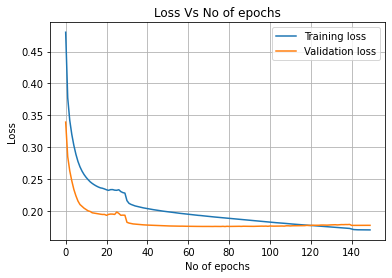

In [44]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

In [0]:
#Generate 1000 random samples from train and val data
#Train data
train_index = []
for i in range(X_train_padded_docs.shape[0]):
    if np.count_nonzero(X_train_padded_docs[i]!=0)>70:
        train_index.append(i)
train_index = random.sample(train_index,1000)

#Validation data
#Train data
val_index = []
for i in range(X_val_padded_docs.shape[0]):
    if np.count_nonzero(X_val_padded_docs[i]!=0)>70:
        val_index.append(i)
val_index = random.sample(val_index,1000)

In [62]:
#For train data, actual and predicted words
train_bleu_list = []
counter = 0
for i,j in tqdm(zip(X_train_padded_docs[train_index,:],y_train_padded_docs[train_index,:])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(model,i,j)
    train_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%100==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

Input sentence: # this website will reduce training costs and increase availability of training t *
Actual words: # o all employees *
Predicted words: # o the company *
------------------------------------------------------------------------------------------
Input sentence: # i will not assume that you want to play unless you send me a confirmation ema *
Actual words: # il *
Predicted words: # il *
------------------------------------------------------------------------------------------
Input sentence: # i have attached the bill for your review but a more detailed analysis wi *
Actual words: # ll follow *
Predicted words: # th the conference *
------------------------------------------------------------------------------------------
Input sentence: # first thank you all for your hard work this last week and in advance for the next we *
Actual words: # eks to come *
Predicted words: # ek *
------------------------------------------------------------------------------------------
Input

In [63]:
#For validation data actual and predicted words
val_bleu_list = []
counter = 0
for i,j in tqdm(zip(X_val_padded_docs[val_index,:],y_val_padded_docs[val_index,:])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(model,i,j)
    val_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%100==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

Input sentence: # also prepare to have your markets covered when you leave the office ear *
Actual words: # ly *
Predicted words: # liest convenience *
------------------------------------------------------------------------------------------
Input sentence: # they want to answer the customer within a week so they will need this informat *
Actual words: # ion at least by early next week *
Predicted words: # ion *
------------------------------------------------------------------------------------------
Input sentence: # a hard copy would be much appreciated but if need be please send vi *
Actual words: # a email *
Predicted words: # ew *
------------------------------------------------------------------------------------------
Input sentence: # i understand that you are busy so please take your time in getting back with the requested inform *
Actual words: # ation *
Predicted words: # ation *
------------------------------------------------------------------------------------------
Inp

In [64]:
#Average BLEU Score for sentences
print('BLEU Score for train data of 1000 samples:',np.round(sum(train_bleu_list)/len(train_bleu_list),3))
print('BLEU Score for validation data of 1000 samples:',np.round(sum(val_bleu_list)/len(val_bleu_list),3))

BLEU Score for train data of 1000 samples: 0.698
BLEU Score for validation data of 1000 samples: 0.689


<h1>4. Predictions

In [0]:
def predict_sentence(enc_dec_model,input_sentence):
    
    #Maximum sequence length for input and target sentence
    input_max_length = X_train_padded_docs.shape[1]
    output_max_length = y_train_padded_docs.shape[1]

    input_sentence = '# ' + input_sentence + ' *'
    
    #Convert texts to sequences
    sent = tokenizer.texts_to_sequences([input_sentence])
    #Pad data
    sent = tf.keras.preprocessing.sequence.pad_sequences(sent,maxlen=input_max_length,padding='post')
    
    #print('Encoder input shape (batch_size,sequence length):',sent.shape)
    enc_hidden,enc_cell = enc_dec_model.layers[0](sent)
    #print('Encoder hidden state shape (batch_size,units):',enc_hidden.shape)
    #print('Encoder cell state shape (batch_size,units):',enc_cell.shape)
    #print(90*'-')
    
    #Boundary case
    dec_input = tf.expand_dims([tokenizer.word_index['#']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    #print('Decoder input shape (batch_size,1):',dec_input.shape)
    #print('Decoder hidden state shape (batch_size,units):',dec_hidden.shape)
    #print('Decoder cell state shape (batch_size,units):',dec_cell.shape)
    output_sent = ''
    
    for i in range(output_max_length-1):
        #Get prediction from onestep_decoder
        dec_output,dec_hidden,dec_cell = enc_dec_model.layers[1](dec_input,dec_hidden,dec_cell)
        #print('Decoder output shape (batch_size,vocab_size):',dec_output.shape)
        #print('Decoder hidden state shape (batch_size,units):',dec_hidden.shape)
        #print('Decoder cell state shape (batch_size,units):',dec_cell.shape)
    
        #Get prediction from dense layer
        #Shape == (batch_size,timestep,vocab_size) == (1,1,30)
        outputs = enc_dec_model.layers[3](dec_output)
        
        #Extract predicted id from decoder output
        key = np.argmax(outputs.numpy().reshape(-1))
        
        #Get word corresponding to index
        output_sent+=tokenizer.index_word[key]
        
        if tokenizer.index_word[key] == '*':
            return output_sent
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 0)
    
    return output_sent

In [65]:
predict_sentence(model,'thank you for')

'  the conference call *'

In [51]:
predict_sentence(model,'hope it')

'  will be a good time *'

In [66]:
predict_sentence(model,'can you give')

'  me a call *'

In [53]:
predict_sentence(model,'give me')

'  a call if you have any questions or comments *'

In [54]:
predict_sentence(model,'are you avail')

' able to discuss this *'

<h1 style="font-size:35px"><center>Encoder Decoder Attention Model

In [0]:
!wget --header="Host: doc-08-44-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://drive.google.com/drive/u/0/folders/1Lze5wKSp2c3rurUo8iet5RgNygcOyW1Z" --header="Cookie: AUTH_bfhjrtscq695ib7edi83p6bfm42sd929=00136369994752382157|1591332075000|khsiv584fse14fsp6qp1a1iov04jc9gc; _ga=GA1.2.1509677474.1591248567; _gid=GA1.2.195823905.1591248567" --header="Connection: keep-alive" "https://doc-08-44-docs.googleusercontent.com/docs/securesc/oik9lo733t355n1nglla0cdlqj79umtt/tv4k6lhqh609hsumjakcisnk9ol47fpj/1591332150000/02963250765125473783/00136369994752382157/1AdAgXbmDo9eDellva8bClMYUsiH5LNo4?e=download&authuser=0" -c -O 'char_encoded_data'

--2020-06-05 04:43:21--  https://doc-08-44-docs.googleusercontent.com/docs/securesc/oik9lo733t355n1nglla0cdlqj79umtt/tv4k6lhqh609hsumjakcisnk9ol47fpj/1591332150000/02963250765125473783/00136369994752382157/1AdAgXbmDo9eDellva8bClMYUsiH5LNo4?e=download&authuser=0
Resolving doc-08-44-docs.googleusercontent.com (doc-08-44-docs.googleusercontent.com)... 64.233.184.132, 2a00:1450:400c:c0b::84
Connecting to doc-08-44-docs.googleusercontent.com (doc-08-44-docs.googleusercontent.com)|64.233.184.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘char_encoded_data’

char_encoded_data       [   <=>              ]  44.83M  52.1MB/s    in 0.9s    

2020-06-05 04:43:23 (52.1 MB/s) - ‘char_encoded_data’ saved [47013427]



<h1>1. Read Featurized data</h1> 
<h2>(Refer Character Featurization Section 3 of 2_Data_Preparation.ipynb)</h2> 

In [0]:
[X_train_padded_docs,y_train_padded_docs,X_val_padded_docs,y_val_padded_docs,
                                             embedding_matrix,tokenizer] = joblib.load('char_encoded_data')

<h1>2. Define Model Architecture

<h2>2.1. Encoder Model

In [0]:
#Encoder class
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,enc_units,**kwargs):
        super(Encoder,self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim,weights=[embedding_matrix],
                                   mask_zero=True,name='Encoder_Embedding_layer')
        self.lstm = LSTM(self.enc_units,return_sequences=True,return_state=True,name='Encoder_LSTM',dropout=0.33)

    def call(self, x):
        x = self.embedding(x)
        #state_h = Hidden state output of last time step (Output of last time step)
        #state_c = Cell state output of last time step
        lstm_out, state_h, state_c = self.lstm(x)
        return lstm_out, state_h, state_c

In [4]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocab size:',vocab_size)

Vocab size: 30


In [5]:
#Create encoder object
BATCH_SIZE = 32
encoder = Encoder(vocab_size=vocab_size,embedding_dim=300,embedding_matrix=embedding_matrix,
                  enc_units=128,name='Encoder')

#Get data from data generator
example_input_batch, example_target_batch = X_train_padded_docs[:BATCH_SIZE], y_train_padded_docs[:BATCH_SIZE]
print('Shape of batch input data (batch_size,sequence length):',example_input_batch.shape)
print('Shape of batch output data (batch_size,sequence length):',example_target_batch.shape)

#Genearte sample ouptput and hidden state from encoder object
sample_output, sample_hidden_output, sample_cell_output = encoder(example_input_batch)
print('Shape of encoder output (batch_size,sequence length,units):',sample_output.shape)
print('Shape of hidden state output of last time step (batch_size,units):',sample_hidden_output.shape)
print('Shape of memory state output of last time step (batch_size,units):',sample_cell_output.shape)

Shape of batch input data (batch_size,sequence length): (32, 53)
Shape of batch output data (batch_size,sequence length): (32, 53)
Shape of encoder output (batch_size,sequence length,units): (32, 53, 128)
Shape of hidden state output of last time step (batch_size,units): (32, 128)
Shape of memory state output of last time step (batch_size,units): (32, 128)


<h2>2.2. Attention layer</h2>

For a particular time step of Decoder, the attention layer takes the output from the encoder (output at all time steps) and decoder output (hidden state output of decoder) at previous time step and computes the context vector. The context vector concatenated with the decoder output of previous time step is given as an input to the decoder for the current time step.

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self,units):
        super(BahdanauAttention,self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        
    def call(self, hs, ht):
        #hs = Encoder output at all time steps
        #ht = Decoder output at last time step (Hidden state output of decoder at last time step)
        #Add time axis to ht, this is done to perform broadcast addition along time axis to calculate score
        #hs shape == (batch size,max_length,hidden size)
        #ht shape == (batch size,hidden size)
        #ht_with_time_axis shape == (batch size,1,hidden size)
        ht_with_time_axis = tf.expand_dims(ht, axis=1)
        
        #score shape == (batch size, max_length, 1)
        score = self.V(tf.nn.tanh(self.W1(ht_with_time_axis) + self.W2(hs)))
        
        #Softmaxing the scores to get attention weights (alpha's)
        #attention_weights shape == (batch size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        #Get context vector
        #context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * hs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [7]:
#Initalise Attention
attention_layer = BahdanauAttention(units=128)
sample_context_vector, sample_attention_weights = attention_layer(sample_output,sample_hidden_output)
print('Shape of context vector (batch_size,units):',sample_context_vector.shape)
print('Shape of attention weights (batch_size,sequence length,1):',sample_attention_weights.shape)

Shape of context vector (batch_size,units): (32, 128)
Shape of attention weights (batch_size,sequence length,1): (32, 53, 1)


<h2>2.3. Decoder Model

<h3>2.3.1. One Step Decoder

In [0]:
class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,dec_units,att_units):
        super(OneStepDecoder, self).__init__()
        self.attention = BahdanauAttention(units=att_units)
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim,weights=[embedding_matrix],mask_zero=True,
                                   name='Decoder_Embedding_layer')
        self.lstm = LSTM(dec_units,return_sequences=False,return_state=True,name='Decoder_LSTM',dropout=0.33)
        self.drop = Dropout(0.2)
        self.fc = Dense(vocab_size)
        
    def call(self, x, hidden, cell, enc_output):
        #enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(enc_output,hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x,initial_state=[hidden,cell])
        
        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state_h, state_c, attention_weights

In [9]:
#Initialise one step decoder with attention
BATCH_SIZE = 32
osd = OneStepDecoder(vocab_size=vocab_size,embedding_dim=300,embedding_matrix=embedding_matrix,dec_units=128,att_units=128)

#Input to decoder for first time step
dec_input = tf.expand_dims([tokenizer.word_index['#']] * BATCH_SIZE, 1)

#Geneate sample output, hidden states and attention weights from decoder object
sample_output_dec,sample_hidden_output_dec,sample_cell_output_dec,sample_attention_weights = osd(dec_input,
                                                                                                 sample_hidden_output, 
                                                                                                 sample_cell_output,
                                                                                                 sample_output)
print('One Step Decoder with Attention:')
print('Shape of decoder output (batch_size,vocab_size):',sample_output_dec.shape)
print('Shape of decoder hidden state output (batch_size,units):',sample_hidden_output_dec.shape)
print('Shape of decoder memory state output (batch_size,units):',sample_cell_output_dec.shape)
print('Shape of attention weights (batch_size,sequence length,1):',sample_attention_weights.shape)

One Step Decoder with Attention:
Shape of decoder output (batch_size,vocab_size): (32, 30)
Shape of decoder hidden state output (batch_size,units): (32, 128)
Shape of decoder memory state output (batch_size,units): (32, 128)
Shape of attention weights (batch_size,sequence length,1): (32, 53, 1)


<h3>2.3.2. Decoder for Training

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,dec_units,att_units,**kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.att_units = att_units
        self.onestep_decoder = OneStepDecoder(vocab_size=self.vocab_size,embedding_dim=self.embedding_dim,
                                              embedding_matrix=embedding_matrix,
                                              dec_units=self.dec_units,
                                              att_units=self.att_units)
        
    #@tf.function
    def call(self,decoder_input,decoder_hidden_state,decoder_cell_state,encoder_outputs):
        
        #Decoder must output words after <start> token hence sequence length is reduced by 1
        all_outputs = tf.TensorArray(tf.float32,size=decoder_input.shape[1]-1,name='Output_arrays')
        
        #Initialise the hidden and cell states of decoder
        hidden_output_dec = decoder_hidden_state
        cell_output_dec = decoder_cell_state
        
        #for each timestep in decoder input (output after <start> token)
        for timestep in range(decoder_input.shape[1]-1):
            #Get the output, hidden states from one step decoder
            output_dec,hidden_output_dec,cell_output_dec,_ = self.onestep_decoder(decoder_input[:,timestep:timestep+1],
                                                                                  hidden_output_dec,cell_output_dec,
                                                                                  encoder_outputs)
            
            #output_dec shape == (batch_size,vocab_size)
            #Storing all outputs
            all_outputs = all_outputs.write(timestep,output_dec)
        #all_outputs shape after stacking == (timestep-1,batch_size,vocab_size)
        #all_outputs shape after transpose == (batch_size,timestep-1,vocab_size)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs

In [11]:
#Initialise decoder
decoder = Decoder(vocab_size=vocab_size,embedding_dim=300,embedding_matrix=embedding_matrix,dec_units=128,att_units=128)

#Generate output from decoder
all_outputs = decoder(example_target_batch,sample_hidden_output,sample_cell_output,sample_output)
print('Decoder with Attention:')
print('Shape of decoder input (batch_size,sequence length):',example_target_batch.shape)
print('Shape of decoder output (batch_size,sequence length-1,vocab_size):',all_outputs.shape)

Decoder with Attention:
Shape of decoder input (batch_size,sequence length): (32, 53)
Shape of decoder output (batch_size,sequence length-1,vocab_size): (32, 52, 30)


<h2>2.4. Loss function

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
    
    #Identify zeros in real tensor/Creating masking tensor
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    #Calculate log loss for each class
    loss_ = loss_object(real, pred)
    #Change data type of mask
    mask = tf.cast(mask, dtype=loss_.dtype)
    #Calculate loss considering masking
    loss_ *= mask

    return tf.reduce_mean(loss_)

<h2>2.5. Model

In [0]:
class Encoder_Decoder_Attention_Model(tf.keras.models.Model):
    def __init__(self, vocab_size,embedding_dim,embedding_matrix,units,att_units,**kwargs):
        super(Encoder_Decoder_Attention_Model,self).__init__(**kwargs)
        self.encoder = Encoder(vocab_size=vocab_size, embedding_dim=embedding_dim,embedding_matrix=embedding_matrix,
                               enc_units=units,name='Encoder_layer')
        self.decoder = Decoder(vocab_size=vocab_size, embedding_dim=embedding_dim,embedding_matrix=embedding_matrix,
                               dec_units=units,att_units=att_units,
                               name='Decoder_layer')
        
    def call(self, inputs):
        #Inputs will contain encoder input and decoder input
        #Separate encoder and decoder inputs
        encoder_inputs, decoder_inputs = inputs[0], inputs[1]
        
        #Genearte output and hidden states from encoder object
        encoder_outputs, enc_hidden_output, enc_cell_output = self.encoder(encoder_inputs)

        #Generate output from decoder
        #Initialise hidden states of decoder with hidden states of encoder
        all_outputs = self.decoder(decoder_inputs,enc_hidden_output,enc_cell_output,encoder_outputs)
        
        return all_outputs

<h2>2.6. Model Evaluation

In [0]:
#Function returns texts from a sequence
def get_text_from_seq(sequence,tokenizer):
    sent =''
    for i in sequence:
        if i!=0:
            sent+=tokenizer.index_word[i]
    return sent

In [0]:
#Function to get bleu score for a sentence
def get_bleu_score(enc_dec_model,input_seq,expected_output_seq):
    
    inp_max_length = X_train_padded_docs.shape[1]
    out_max_length = y_train_padded_docs.shape[1]
    
    #Get output from encoder
    enc_outputs,enc_hidden,enc_cell = enc_dec_model.layers[0](input_seq.reshape(1,inp_max_length))
    
    #Boundary case for decoder
    dec_input = tf.expand_dims([tokenizer.word_index['#']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    
    #Predicted output sequence
    #Add <start> token to output sequence
    output_seq = [tokenizer.word_index['#']]
    
    #The model will start predicting after start token, hence max_length is subtracted by 1
    for i in range(out_max_length-1):
        #Get prediction from onestep_decoder
        dec_output,dec_hidden,dec_cell,_ = enc_dec_model.layers[1].onestep_decoder(dec_input,dec_hidden,
                                                                                               dec_cell,enc_outputs)
        
        #Extract predicted id from decoder output
        key = tf.argmax(dec_output[0]).numpy()
        
        output_seq.append(key)
        
        if tokenizer.index_word[key] == '*':
            #Get texts from input sentence
            input_sent = get_text_from_seq(input_seq,tokenizer)
            #Get texts from sequence for actual sentence
            actual = get_text_from_seq(expected_output_seq,tokenizer)
            #Get texts from sequence for predicted sentence
            prediction = get_text_from_seq(output_seq,tokenizer)
            return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 0)
    
    input_sent = get_text_from_seq(input_seq,tokenizer)
    actual = get_text_from_seq(expected_output_seq,tokenizer)
    prediction = get_text_from_seq(output_seq,tokenizer)
    return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())

<h1>3. Model Training

In [0]:
#Set Parameters
vocab_size = len(tokenizer.word_index) + 1  

#Encoding and decoding Embedding layer dimension
embedding_dim = 300

#Encoding and decoding LSTM layer units
units = 128
att_units = 32

#Initialise object for Model class
model = Encoder_Decoder_Attention_Model(vocab_size,embedding_dim,embedding_matrix,units,att_units,
                                        name='Encoder_Decoder_Attention_Model')

In [18]:
#Max sequence length for input and output sentence
model.build(input_shape=[(None,X_train_padded_docs.shape[1]),(None,y_train_padded_docs.shape[1])])
model.summary()

Model: "Encoder_Decoder_Attention_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_layer (Encoder)      multiple                  228648    
_________________________________________________________________
Decoder_layer (Decoder)      multiple                  306343    
Total params: 534,991
Trainable params: 534,991
Non-trainable params: 0
_________________________________________________________________


In [0]:
def data_generator(X,y,BATCH_SIZE,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(len(X)).batch(BATCH_SIZE,drop_remainder=True)
    else:
        dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
#Create folder to save model weights
if not os.path.isdir('model_save'):
    os.makedirs('model_save')

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [22]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 10

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list = [checkpoint,tensorboard_callback]

#Data generator
train = data_generator((X_train_padded_docs,y_train_padded_docs),y_train_padded_docs[:,1:],
                       BATCH_SIZE=BATCH_SIZE,shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history1 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/10
209/209 [==============================] - ETA: 0s - loss: 0.7767
Epoch 00001: loss improved from inf to 0.77665, saving model to model_save/weights-01-0.7767.hdf5
209/209 [==============================] - 148s 706ms/step - loss: 0.7767 - val_loss: 0.4650
Epoch 2/10
209/209 [==============================] - ETA: 0s - loss: 0.5602
Epoch 00002: loss improved from 0.77665 to 0.56016, saving model to model_save/weights-02-0.5602.hdf5
209/209 [==============================] - 124s 593ms/step - loss: 0.5602 - val_loss: 0.3880
Epoch 3/10
209/209 [==============================] - ETA: 0s - loss: 0.4899
Epoch 00003: loss improved from 0.56016 to 0.48995, saving model to model_save/weights-03-0.4899.hdf5
209/209 [==============================] - 124s 592ms/step - loss: 0.4899 - val_loss: 0.3557
Epoch 4/10
209/209 [==============================] - ETA: 0s - loss: 0.4537
Epoch 00004: loss improved from 0.48995 to 0.45367, saving model to model_save/weights-04-0.4537.hdf5
209/209 [

In [23]:
joblib.dump(history1.history,'history1')

['history1']

In [0]:
#Save weights
model.save_weights('best_model1.h5')

In [25]:
train_parameters = model.evaluate([X_train_padded_docs,y_train_padded_docs],y_train_padded_docs[:,1:],
                                  verbose=1,batch_size=BATCH_SIZE)

210/210 [==============================] - 42s 201ms/step - loss: 0.3632


In [26]:
val_parameters = model.evaluate([X_val_padded_docs,y_val_padded_docs],y_val_padded_docs[:,1:],
                                 verbose=1,batch_size=BATCH_SIZE)

29/29 [==============================] - 6s 196ms/step - loss: 0.3129


In [0]:
#Load weights
model.load_weights('best_model1.h5')

In [28]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 10

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Data generator
train = data_generator((X_train_padded_docs,y_train_padded_docs),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history2 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/10
209/209 [==============================] - ETA: 0s - loss: 0.3756
Epoch 00001: loss improved from 0.37872 to 0.37559, saving model to model_save/weights-01-0.3756.hdf5
209/209 [==============================] - 150s 717ms/step - loss: 0.3756 - val_loss: 0.3126
Epoch 2/10
209/209 [==============================] - ETA: 0s - loss: 0.3670
Epoch 00002: loss improved from 0.37559 to 0.36695, saving model to model_save/weights-02-0.3670.hdf5
209/209 [==============================] - 123s 589ms/step - loss: 0.3670 - val_loss: 0.3126
Epoch 3/10
209/209 [==============================] - ETA: 0s - loss: 0.3616
Epoch 00003: loss improved from 0.36695 to 0.36157, saving model to model_save/weights-03-0.3616.hdf5
209/209 [==============================] - 124s 592ms/step - loss: 0.3616 - val_loss: 0.3134
Epoch 4/10
209/209 [==============================] - ETA: 0s - loss: 0.3578
Epoch 00004: loss improved from 0.36157 to 0.35783, saving model to model_save/weights-04-0.3578.hdf5
209/2

In [29]:
joblib.dump(history2.history,'history2')

['history2']

In [0]:
#Save weights
model.save_weights('best_model2.h5')

In [0]:
model.load_weights('best_model2.h5')

In [32]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 30

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Stop training if val_loss does not decrease in last 8 epochs
terminate = EarlyStopping(monitor='val_loss',patience=8,verbose=1,mode='min',restore_best_weights=True)

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list = [checkpoint,terminate,tensorboard_callback]

#Data generator
train = data_generator((X_train_padded_docs,y_train_padded_docs),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history3 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/30
209/209 [==============================] - ETA: 0s - loss: 0.3253
Epoch 00001: loss improved from inf to 0.32529, saving model to model_save/weights-01-0.3253.hdf5
209/209 [==============================] - 151s 721ms/step - loss: 0.3253 - val_loss: 0.2953
Epoch 2/30
209/209 [==============================] - ETA: 0s - loss: 0.3130
Epoch 00002: loss improved from 0.32529 to 0.31297, saving model to model_save/weights-02-0.3130.hdf5
209/209 [==============================] - 125s 596ms/step - loss: 0.3130 - val_loss: 0.2938
Epoch 3/30
209/209 [==============================] - ETA: 0s - loss: 0.3086
Epoch 00003: loss improved from 0.31297 to 0.30855, saving model to model_save/weights-03-0.3086.hdf5
209/209 [==============================] - 124s 596ms/step - loss: 0.3086 - val_loss: 0.2929
Epoch 4/30
209/209 [==============================] - ETA: 0s - loss: 0.3054
Epoch 00004: loss improved from 0.30855 to 0.30543, saving model to model_save/weights-04-0.3054.hdf5
209/209 [

In [33]:
joblib.dump(history3.history,'history3')

['history3']

In [0]:
#Save weights
model.save_weights('best_model3.h5')

In [35]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 30

#Model compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Reduce learning rate by 10% if validation loss does not decrease from last 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, verbose=1, patience=2,min_lr=0.00001)

#Stop training if val_loss does not decrease in last 8 epochs
terminate = EarlyStopping(monitor='val_loss',patience=8,verbose=1,mode='min',restore_best_weights=True)

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list = [checkpoint,reduce_lr,terminate,tensorboard_callback]

#Data generator
train = data_generator((X_train_padded_docs,y_train_padded_docs),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history4 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/30
209/209 [==============================] - ETA: 0s - loss: 0.2884
Epoch 00001: loss improved from inf to 0.28844, saving model to model_save/weights-01-0.2884.hdf5
209/209 [==============================] - 151s 722ms/step - loss: 0.2884 - val_loss: 0.2911 - lr: 1.0000e-04
Epoch 2/30
209/209 [==============================] - ETA: 0s - loss: 0.2871
Epoch 00002: loss improved from 0.28844 to 0.28713, saving model to model_save/weights-02-0.2871.hdf5
209/209 [==============================] - 125s 596ms/step - loss: 0.2871 - val_loss: 0.2909 - lr: 1.0000e-04
Epoch 3/30
209/209 [==============================] - ETA: 0s - loss: 0.2867
Epoch 00003: loss improved from 0.28713 to 0.28666, saving model to model_save/weights-03-0.2867.hdf5
209/209 [==============================] - 125s 597ms/step - loss: 0.2867 - val_loss: 0.2908 - lr: 1.0000e-04
Epoch 4/30
209/209 [==============================] - ETA: 0s - loss: 0.2863
Epoch 00004: loss improved from 0.28666 to 0.28630, saving m

In [36]:
joblib.dump(history4.history,'history4')

['history4']

In [0]:
#Save weights
model.save_weights('best_model4.h5')

In [0]:
h1 = joblib.load('history1')
h2 = joblib.load('history2')
h3 = joblib.load('history3')
h4 = joblib.load('history4')

In [0]:
loss = h1['loss']+h2['loss']+h3['loss']+h4['loss']
val_loss = h1['val_loss']+h2['val_loss']+h3['val_loss']+h4['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

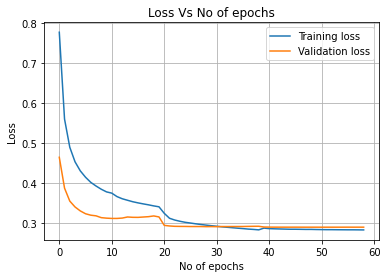

In [41]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

In [0]:
#Generate 1000 random samples from train and val data
#Train data
train_index = []
for i in range(X_train_padded_docs.shape[0]):
    if np.count_nonzero(X_train_padded_docs[i]!=0)>10:
        train_index.append(i)
train_index = random.sample(train_index,1000)

#Validation data
#Train data
val_index = []
for i in range(X_val_padded_docs.shape[0]):
    if np.count_nonzero(X_val_padded_docs[i]!=0)>10:
        val_index.append(i)
val_index = random.sample(val_index,1000)

In [68]:
#For train data, actual and predicted words
train_bleu_list = []
counter = 0
for i,j in tqdm(zip(X_train_padded_docs[train_index,:],y_train_padded_docs[train_index,:])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(model,i,j)
    train_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%100==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

101it [00:17,  6.68it/s]

Input sentence: # again any questions comm *
Actual words: # ents concerns let me know *
Predicted words: # ents concerns *
------------------------------------------------------------------------------------------


199it [00:35,  3.33it/s]

Input sentence: # please contact me with any concern *
Actual words: # s or questions *
Predicted words: # s *
------------------------------------------------------------------------------------------


300it [00:55,  5.20it/s]

Input sentence: # do not worry about having *
Actual words: #  to have a gift ready *
Predicted words: #  to have a great *
------------------------------------------------------------------------------------------


400it [01:13,  4.96it/s]

Input sentence: # i have all his  *
Actual words: # information if you need it *
Predicted words: # sure you are coming *
------------------------------------------------------------------------------------------


501it [01:30,  5.44it/s]

Input sentence: # under the ap *
Actual words: # propriate desk of course *
Predicted words: # preciated to the company *
------------------------------------------------------------------------------------------


600it [01:47,  6.95it/s]

Input sentence: # we are trying to  *
Actual words: # schedule this gas for today *
Predicted words: # the morning *
------------------------------------------------------------------------------------------


700it [02:06,  4.61it/s]

Input sentence: # there never w *
Actual words: # as any deregulation *
Predicted words: # e have a good time *
------------------------------------------------------------------------------------------


801it [02:25,  6.55it/s]

Input sentence: # please let me know how this works for y *
Actual words: # ou *
Predicted words: # ou *
------------------------------------------------------------------------------------------


900it [02:43,  5.16it/s]

Input sentence: # great that he could come over *
Actual words: #  and visit *
Predicted words: #  the problems *
------------------------------------------------------------------------------------------


1000it [03:04,  5.43it/s]

Input sentence: # let me know if you ha *
Actual words: # ve comments or concerns *
Predicted words: # ve any questions *
------------------------------------------------------------------------------------------


In [69]:
#For validation data actual and predicted words
val_bleu_list = []
counter = 0
for i,j in tqdm(zip(X_val_padded_docs[val_index,:],y_val_padded_docs[val_index,:])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(model,i,j)
    val_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%100==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

100it [00:16,  6.05it/s]

Input sentence: # we apologize for the late distribution th *
Actual words: # is month *
Predicted words: # e past *
------------------------------------------------------------------------------------------


201it [00:32,  8.35it/s]

Input sentence: # i am not asking for approva *
Actual words: # l to do this *
Predicted words: # ted *
------------------------------------------------------------------------------------------


300it [00:49,  4.04it/s]

Input sentence: # i definitely *
Actual words: #  need to meet some new people *
Predicted words: #  they are the past on the same *
------------------------------------------------------------------------------------------


401it [01:07,  6.10it/s]

Input sentence: # i will have her cont *
Actual words: # act you later today *
Predicted words: # inue to you *
------------------------------------------------------------------------------------------


502it [01:24,  6.65it/s]

Input sentence: # we will not accept such orders or i *
Actual words: # nstructions *
Predicted words: # n the online *
------------------------------------------------------------------------------------------


600it [01:42,  6.14it/s]

Input sentence: # let me know the final reso *
Actual words: # lution on this one *
Predicted words: # lve *
------------------------------------------------------------------------------------------


701it [01:59,  6.03it/s]

Input sentence: # after that j *
Actual words: # ust enjoy the games *
Predicted words: # ust story *
------------------------------------------------------------------------------------------


801it [02:16,  5.87it/s]

Input sentence: # thanks so much for all your help an *
Actual words: # d hard work *
Predicted words: # d suggestions *
------------------------------------------------------------------------------------------


901it [02:33,  5.20it/s]

Input sentence: # i received this and thought it w *
Actual words: # as great *
Predicted words: # ill be a completed *
------------------------------------------------------------------------------------------


1000it [02:49,  5.89it/s]

Input sentence: # that is exactly what we are lookin *
Actual words: # g for *
Predicted words: # g *
------------------------------------------------------------------------------------------


In [70]:
#Average BLEU Score for sentences
print('BLEU Score for train data of 1000 samples:',np.round(sum(train_bleu_list)/len(train_bleu_list),3))
print('BLEU Score for validation data of 1000 samples:',np.round(sum(val_bleu_list)/len(val_bleu_list),3))

BLEU Score for train data of 1000 samples: 0.649
BLEU Score for validation data of 1000 samples: 0.653


<h1>4. Predictions

In [0]:
def predict_sentence(enc_dec_model,input_sentence):
    
    #Maximum sequence length for input and target sentence
    inp_max_length = X_train_padded_docs.shape[1]
    out_max_length = y_train_padded_docs.shape[1]
    
    #Attention plot
    attention_plot = np.zeros((inp_max_length,out_max_length))
    
    input_sentence = '# ' + input_sentence + ' *'
    
    #Convert texts to sequences
    sent = tokenizer.texts_to_sequences([input_sentence])
    #Pad data
    sent = tf.keras.preprocessing.sequence.pad_sequences(sent,maxlen=inp_max_length,padding='post')
    
    #print('Encoder input shape (batch_size,sequence length):',sent.shape)
    enc_outputs,enc_hidden,enc_cell = enc_dec_model.layers[0](sent)
    #print('Encoder output shape (batch_size,sequence lengths,units):',enc_outputs.shape)
    #print('Encoder hidden state shape (batch_size,units):',enc_hidden.shape)
    #print('Encoder cell state shape (batch_size,units):',enc_cell.shape)
    #print(90*'-')
    
    #Boundary case
    dec_input = tf.expand_dims([tokenizer.word_index['#']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    #print('Decoder input shape (batch_size,1):',dec_input.shape)
    #print('Decoder hidden state shape (batch_size,units):',dec_hidden.shape)
    #print('Decoder cell state shape (batch_size,units):',dec_cell.shape)
    output_sent = ''
    
    for i in range(out_max_length-1):
        #Get prediction from onestep_decoder
        dec_output,dec_hidden,dec_cell,attention_weights = enc_dec_model.layers[1].onestep_decoder(dec_input,dec_hidden,
                                                                                               dec_cell,enc_outputs)
        #print('Decoder output shape (batch_size,vocab_size):',dec_output.shape)
        #print('Decoder hidden state shape (batch_size,units):',dec_hidden.shape)
        #print('Decoder cell state shape (batch_size,units):',dec_cell.shape)
    
        #Storing attention weights
        attention_weights = tf.reshape(attention_weights,(-1,))
        attention_plot[i] = attention_weights.numpy()
        
        #Extract predicted id from decoder output
        key = tf.argmax(dec_output[0]).numpy()
        #Get word corresponding to index
        output_sent+=tokenizer.index_word[key]+''
        
        if tokenizer.index_word[key] == '*':
            return output_sent,input_sentence,attention_plot
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 0)
    
    return output_sent,input_sentence,attention_plot

In [0]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention#write_the_encoder_and_decoder_model
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def generate_sentence(enc_dec_model,input_sentence):
    #Get prediction from model
    result,sentence,attention_plot = predict_sentence(enc_dec_model,input_sentence)
    print('Input sentence:',sentence)
    print('Predicted words:',result)
    #Plot Attention plots
    attention_plot = attention_plot[:len(list(result)),:len(list(sentence))]
    plot_attention(attention_plot, list(sentence), list(result))

Input sentence: # thank you *
Predicted words:   this weekend *


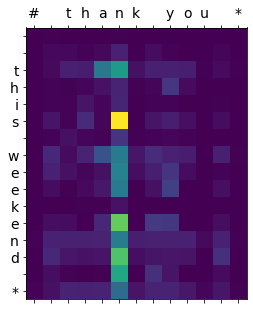

In [82]:
input_sentence = 'thank you'
generate_sentence(model,input_sentence)

Input sentence: # hope it *
Predicted words:   is a while you soon *


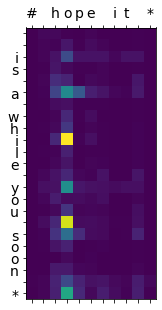

In [83]:
input_sentence = 'hope it'
generate_sentence(model,input_sentence)

Input sentence: # can you *
Predicted words:   have any questions or concerns *


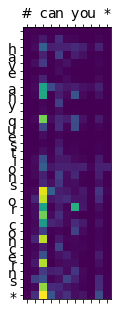

In [84]:
input_sentence = 'can you'
generate_sentence(model,input_sentence)

Input sentence: # give me *
Predicted words:   a call if you need anything *


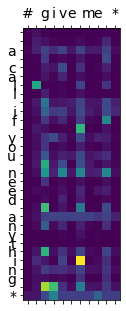

In [85]:
input_sentence = 'give me'
generate_sentence(model,input_sentence)

Input sentence: # are you avail *
Predicted words:  able to assistance in the morning *


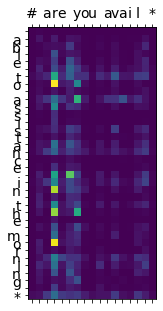

In [86]:
input_sentence = 'are you avail'
generate_sentence(model,input_sentence)